Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters: {'C': 3.845401188473625, 'gamma': 0.10507143064099161, 'kernel': 'rbf'}
Accuracy: 97.56%
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       456
           1       0.97      0.98      0.98       446

    accuracy                           0.98       902
   macro avg       0.98      0.98      0.98       902
weighted avg       0.98      0.98      0.98       902

Confusion Matrix:
[[442  14]
 [  8 438]]


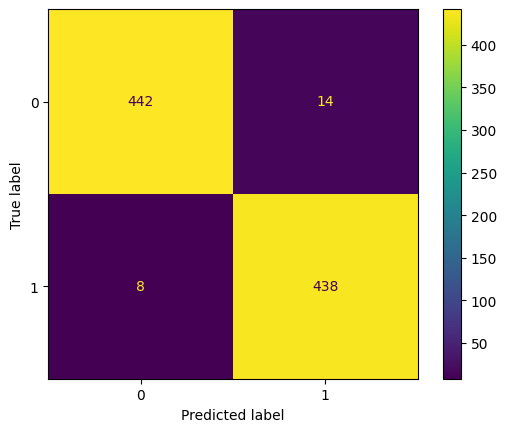

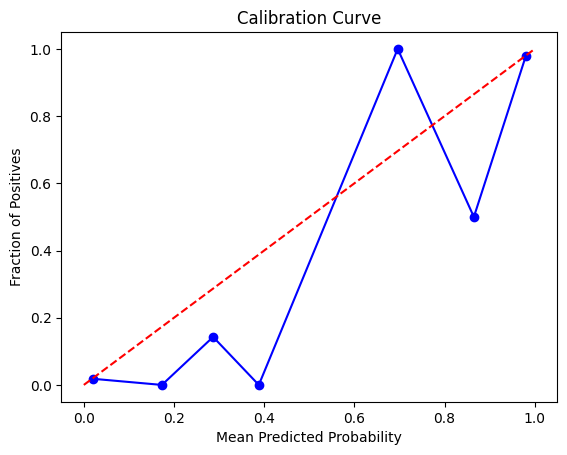

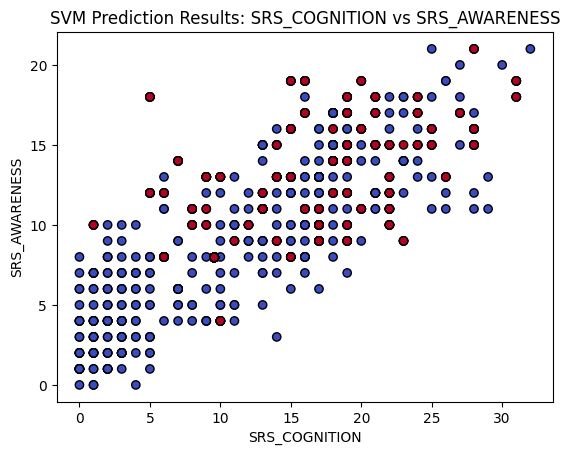

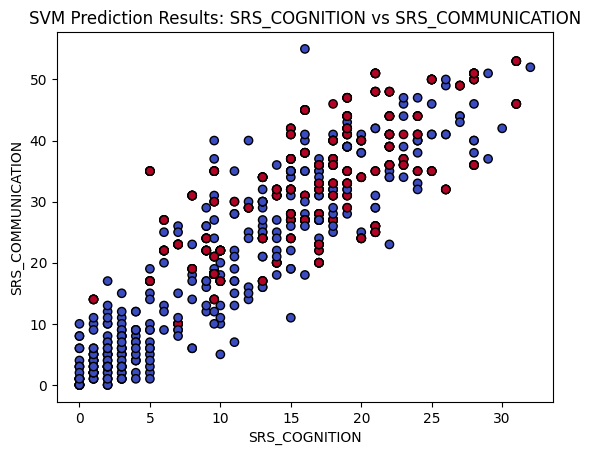

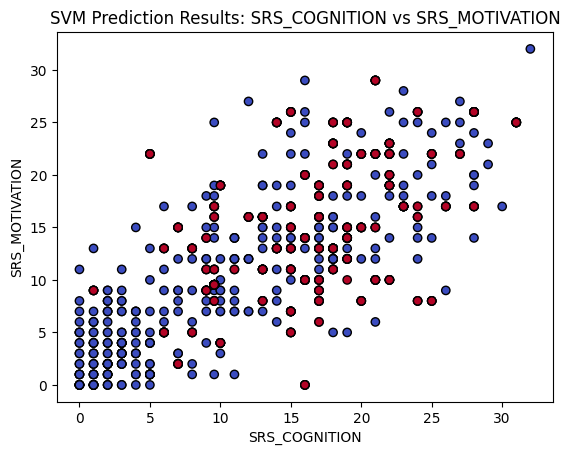

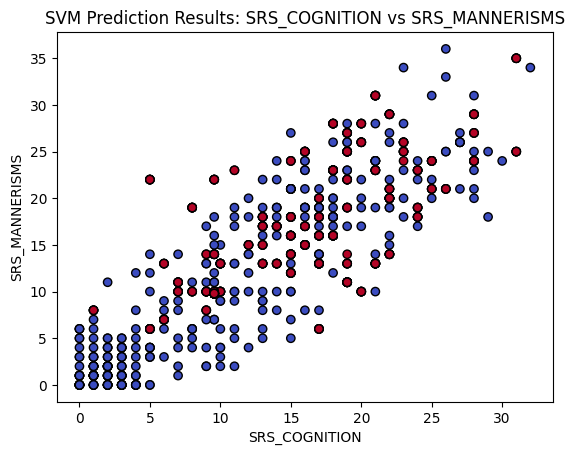

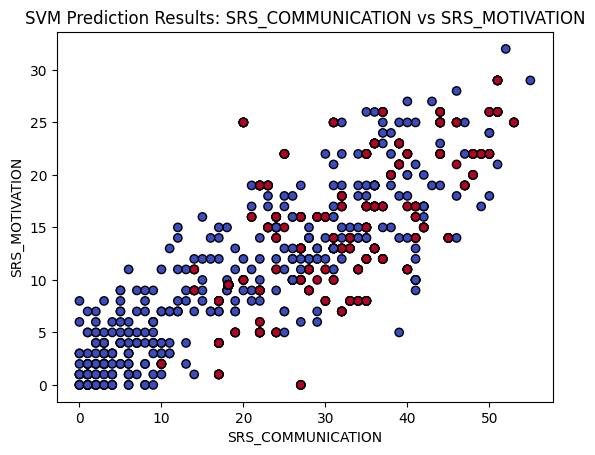

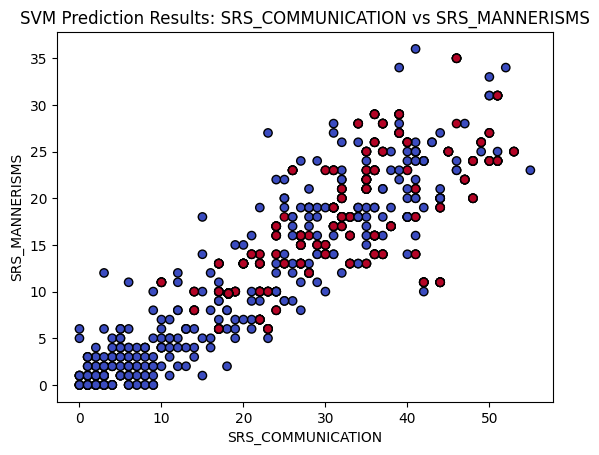

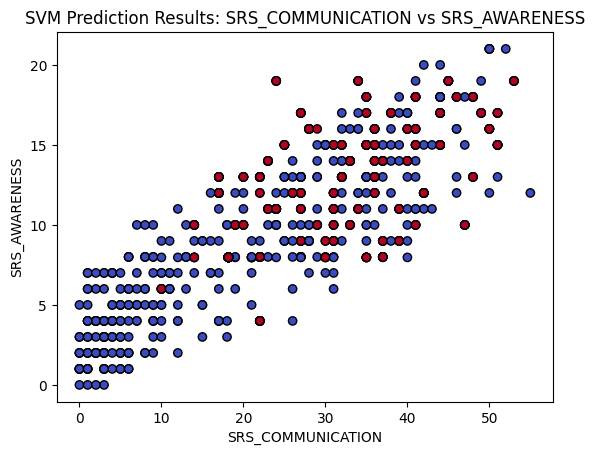

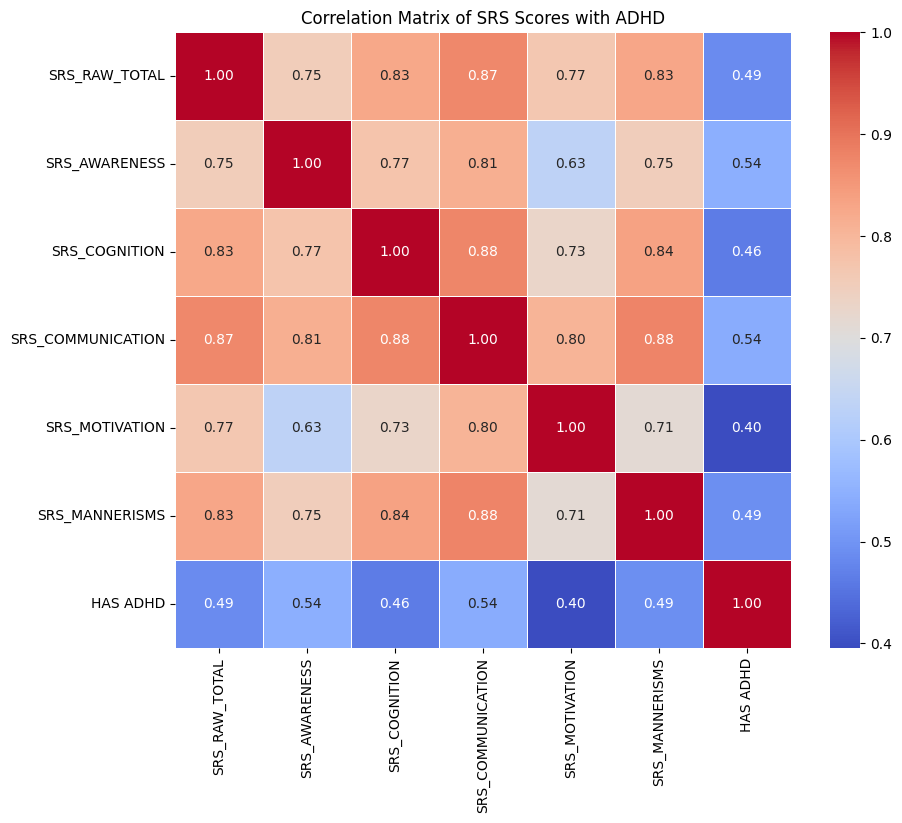

SRS_RAW_TOTAL: 0.4530
SRS_AWARENESS: 0.2943
SRS_COGNITION: 0.3555
SRS_COMMUNICATION: 0.4043
SRS_MOTIVATION: 0.3508
SRS_MANNERISMS: 0.3647


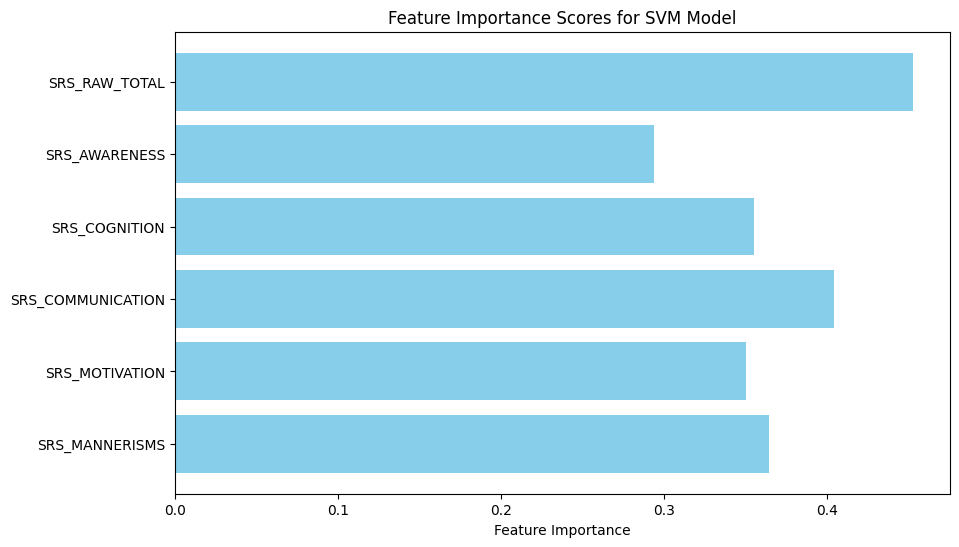

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import joblib
from scipy.stats import uniform
import seaborn as sns
from sklearn.inspection import permutation_importance

Dataset = "../input/srsno-avg2"
training_df = pd.read_csv(Dataset + "/MLsheet - SRSno-avg.csv")

srs_scores = ['SRS_RAW_TOTAL', 'SRS_AWARENESS', 'SRS_COGNITION', 'SRS_COMMUNICATION', 'SRS_MOTIVATION', 'SRS_MANNERISMS']
filtered_df = training_df.dropna(subset=srs_scores + ['HAS ADHD'])

X = filtered_df[srs_scores]
y = filtered_df['HAS ADHD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.44, random_state=42)

svm_model = SVC(probability=True)
param_dist = {
    'C': uniform(0.1, 10),
    'gamma': uniform(0.01, 0.1),
    'kernel': ['rbf', 'sigmoid']
}
random_search = RandomizedSearchCV(svm_model, param_distributions=param_dist, n_iter=5, cv=5, verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

print(f"Best Parameters: {random_search.best_params_}")

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

y_prob = best_model.predict_proba(X_test)[:, 1]

# Calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=8)
plt.plot(prob_pred, prob_true, marker='o', linestyle='-', color='b')
plt.plot([0, 1], [0, 1], linestyle='--', color='r')
plt.title("Calibration Curve")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.show()

# Scatter plots 
srs_pairs = [
    ('SRS_COGNITION','SRS_AWARENESS'),
    ('SRS_COGNITION', 'SRS_COMMUNICATION'),
    ('SRS_COGNITION', 'SRS_MOTIVATION'),
    ('SRS_COGNITION', 'SRS_MANNERISMS'),
    ('SRS_COMMUNICATION', 'SRS_MOTIVATION'),
    ('SRS_COMMUNICATION', 'SRS_MANNERISMS'),
    ('SRS_COMMUNICATION', 'SRS_AWARENESS'),
]

for x_var, y_var in srs_pairs:
    plt.scatter(X_test[x_var], X_test[y_var], c=y_pred, cmap='coolwarm', marker='o', edgecolors='k')
    plt.title(f"SVM Prediction Results: {x_var} vs {y_var}")
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    plt.show()

X_test_with_target = X_test.copy()
X_test_with_target['HAS ADHD'] = y_test

corr_matrix = X_test_with_target.corr()

# correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, square=True, linewidths=0.5)
plt.title("Correlation Matrix of SRS Scores with ADHD")
plt.show()

joblib.dump(best_model, 'best_svm_model.pkl')

result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
importance_scores = result.importances_mean

#  feature importance
for i in range(len(srs_scores)):
    print(f"{srs_scores[i]}: {importance_scores[i]:.4f}")

features = ['SRS_RAW_TOTAL', 'SRS_AWARENESS', 'SRS_COGNITION', 'SRS_COMMUNICATION', 'SRS_MOTIVATION', 'SRS_MANNERISMS']
importances = [0.4530, 0.2943, 0.3555, 0.4043, 0.3508, 0.3647]

plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance Scores for SVM Model')
plt.gca().invert_yaxis()
plt.show()